# Sample DCGAN Implementation using Keras

Adapted from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np

from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


## Helper

In [2]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig('images/fashion_mnist_{}.png'.format(epoch))

## Build Discriminator

In [4]:
def build_discriminator():
    model = Sequential([
        Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        ZeroPadding2D(padding=((0, 1), (0, 1))),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(256, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [5]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

## Build Generator

In [6]:
def build_generator():
    model = Sequential([
        Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim),
        Reshape((7, 7, 128)),
        UpSampling2D(),
        Conv2D(128, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.8),
        Activation('relu'),
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.8),
        Activation('relu'),
        Conv2D(channels, kernel_size=3, padding='same'),
        Activation('tanh')])

    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [7]:
# Build the generator
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

## Create Combined Model

In [8]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

## Some Settings

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [10]:
optimizer = Adam(0.0002, 0.5)

In [11]:
epochs=4000
batch_size=128
save_interval=50

## Load the Data

In [ ]:
# Load the dataset
(X_train, _), (_, _) = fashion_mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

## Adversarial Training

In [ ]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.013427, acc.: 36.33%] [G loss: 0.838593]
1 [D loss: 0.689931, acc.: 61.33%] [G loss: 1.082216]
2 [D loss: 0.498817, acc.: 76.56%] [G loss: 1.195244]
3 [D loss: 0.314810, acc.: 88.67%] [G loss: 1.233083]
4 [D loss: 0.291681, acc.: 92.58%] [G loss: 0.995633]
5 [D loss: 0.311629, acc.: 91.41%] [G loss: 0.836945]
6 [D loss: 0.510992, acc.: 71.88%] [G loss: 1.233273]
7 [D loss: 1.048387, acc.: 44.92%] [G loss: 1.805117]
8 [D loss: 0.861059, acc.: 50.39%] [G loss: 2.076604]
9 [D loss: 0.703365, acc.: 63.67%] [G loss: 1.659870]
10 [D loss: 0.705577, acc.: 58.98%] [G loss: 1.269588]
11 [D loss: 0.806849, acc.: 57.81%] [G loss: 1.244604]
12 [D loss: 0.565169, acc.: 68.75%] [G loss: 0.978281]
13 [D loss: 0.404431, acc.: 80.86%] [G loss: 0.613029]
14 [D loss: 0.242990, acc.: 90.62%] [G loss: 0.261609]
15 [D loss: 0.162529, acc.: 96.88%] [G loss: 0.208700]
16 [D loss: 0.264576, acc.: 88.28%] [G loss: 0.176445]
17 [D loss: 0.221579, acc.: 92.19%] [G loss: 0.339006]
18 [D loss: 0.763173

150 [D loss: 0.811695, acc.: 53.91%] [G loss: 1.030593]
151 [D loss: 0.724492, acc.: 55.08%] [G loss: 1.027270]
152 [D loss: 0.643461, acc.: 60.16%] [G loss: 0.961689]
153 [D loss: 0.571365, acc.: 69.14%] [G loss: 0.895013]
154 [D loss: 0.509656, acc.: 75.78%] [G loss: 0.649275]
155 [D loss: 0.546302, acc.: 70.70%] [G loss: 0.626719]
156 [D loss: 0.520370, acc.: 74.22%] [G loss: 0.567697]
157 [D loss: 0.685764, acc.: 63.67%] [G loss: 0.787073]
158 [D loss: 0.571359, acc.: 71.48%] [G loss: 0.818330]
159 [D loss: 0.879096, acc.: 46.48%] [G loss: 0.997961]
160 [D loss: 0.977728, acc.: 35.55%] [G loss: 1.091449]
161 [D loss: 0.866107, acc.: 40.23%] [G loss: 1.263009]
162 [D loss: 0.764230, acc.: 53.12%] [G loss: 1.171601]
163 [D loss: 0.768965, acc.: 54.30%] [G loss: 1.056653]
164 [D loss: 0.795215, acc.: 49.61%] [G loss: 1.081575]
165 [D loss: 0.612575, acc.: 67.58%] [G loss: 1.049540]
166 [D loss: 0.604995, acc.: 69.14%] [G loss: 0.906240]
167 [D loss: 0.566320, acc.: 71.48%] [G loss: 0.

298 [D loss: 0.693259, acc.: 60.16%] [G loss: 1.234912]
299 [D loss: 0.687113, acc.: 61.72%] [G loss: 1.212025]
300 [D loss: 0.671372, acc.: 59.77%] [G loss: 1.282605]
301 [D loss: 0.777236, acc.: 50.78%] [G loss: 1.227944]
302 [D loss: 0.772507, acc.: 48.83%] [G loss: 1.195062]
303 [D loss: 0.739184, acc.: 57.42%] [G loss: 1.076775]
304 [D loss: 0.676785, acc.: 60.55%] [G loss: 1.218501]
305 [D loss: 0.746585, acc.: 53.91%] [G loss: 1.143718]
306 [D loss: 0.685251, acc.: 58.59%] [G loss: 1.213570]
307 [D loss: 0.689390, acc.: 61.33%] [G loss: 1.074816]
308 [D loss: 0.638341, acc.: 63.67%] [G loss: 1.067286]
309 [D loss: 0.743712, acc.: 51.95%] [G loss: 1.120199]
310 [D loss: 0.696250, acc.: 58.20%] [G loss: 1.194311]
311 [D loss: 0.655207, acc.: 60.16%] [G loss: 1.213658]
312 [D loss: 0.692902, acc.: 57.03%] [G loss: 1.197322]
313 [D loss: 0.728213, acc.: 54.69%] [G loss: 1.197524]
314 [D loss: 0.669172, acc.: 60.16%] [G loss: 1.269501]
315 [D loss: 0.754947, acc.: 54.69%] [G loss: 1.

447 [D loss: 0.570137, acc.: 71.48%] [G loss: 1.175054]
448 [D loss: 0.632980, acc.: 63.28%] [G loss: 1.219013]
449 [D loss: 0.635729, acc.: 63.67%] [G loss: 1.050416]
450 [D loss: 0.695602, acc.: 55.86%] [G loss: 1.184610]
451 [D loss: 0.654678, acc.: 62.50%] [G loss: 1.240414]
452 [D loss: 0.742313, acc.: 54.30%] [G loss: 1.182826]
453 [D loss: 0.765583, acc.: 52.73%] [G loss: 1.197411]
454 [D loss: 0.612826, acc.: 68.36%] [G loss: 1.133950]
455 [D loss: 0.664981, acc.: 62.89%] [G loss: 1.278081]
456 [D loss: 0.771201, acc.: 52.73%] [G loss: 1.161613]
457 [D loss: 0.677825, acc.: 57.81%] [G loss: 1.191197]
458 [D loss: 0.740821, acc.: 53.12%] [G loss: 1.165547]
459 [D loss: 0.630780, acc.: 64.84%] [G loss: 1.089104]
460 [D loss: 0.589766, acc.: 66.80%] [G loss: 1.191598]
461 [D loss: 0.624855, acc.: 64.45%] [G loss: 1.185433]
462 [D loss: 0.607498, acc.: 64.84%] [G loss: 1.143136]
463 [D loss: 0.688935, acc.: 59.77%] [G loss: 1.194604]
464 [D loss: 0.653781, acc.: 60.94%] [G loss: 1.

600 [D loss: 0.673563, acc.: 62.50%] [G loss: 1.152684]
601 [D loss: 0.699380, acc.: 59.77%] [G loss: 1.028024]
602 [D loss: 0.616430, acc.: 64.45%] [G loss: 1.138676]
603 [D loss: 0.631704, acc.: 62.50%] [G loss: 1.115934]
604 [D loss: 0.637688, acc.: 60.94%] [G loss: 1.197001]
605 [D loss: 0.645997, acc.: 61.72%] [G loss: 1.268778]
606 [D loss: 0.640588, acc.: 60.16%] [G loss: 1.094145]
607 [D loss: 0.615997, acc.: 67.19%] [G loss: 1.103088]
608 [D loss: 0.653619, acc.: 61.72%] [G loss: 1.050993]
609 [D loss: 0.637203, acc.: 62.50%] [G loss: 1.212436]
610 [D loss: 0.675879, acc.: 60.55%] [G loss: 1.185220]
611 [D loss: 0.740070, acc.: 58.59%] [G loss: 1.031374]
612 [D loss: 0.665187, acc.: 59.38%] [G loss: 1.116443]
613 [D loss: 0.711859, acc.: 53.91%] [G loss: 1.120247]
614 [D loss: 0.638296, acc.: 62.50%] [G loss: 1.223869]
615 [D loss: 0.663600, acc.: 63.28%] [G loss: 1.165335]
616 [D loss: 0.606920, acc.: 67.19%] [G loss: 1.215506]
617 [D loss: 0.695822, acc.: 57.42%] [G loss: 1.

750 [D loss: 0.645846, acc.: 62.11%] [G loss: 1.061641]
751 [D loss: 0.670637, acc.: 58.98%] [G loss: 1.154931]
752 [D loss: 0.731135, acc.: 55.08%] [G loss: 1.032271]
753 [D loss: 0.693509, acc.: 56.25%] [G loss: 1.094195]
754 [D loss: 0.683587, acc.: 60.55%] [G loss: 1.037787]
755 [D loss: 0.669129, acc.: 59.77%] [G loss: 1.062278]
756 [D loss: 0.710945, acc.: 55.08%] [G loss: 1.050170]
757 [D loss: 0.669194, acc.: 62.11%] [G loss: 1.106254]
758 [D loss: 0.631831, acc.: 62.11%] [G loss: 1.027942]
759 [D loss: 0.613286, acc.: 67.19%] [G loss: 1.049852]
760 [D loss: 0.635330, acc.: 65.23%] [G loss: 1.198644]
761 [D loss: 0.711639, acc.: 55.47%] [G loss: 1.106446]
762 [D loss: 0.694748, acc.: 56.64%] [G loss: 1.118474]
763 [D loss: 0.746409, acc.: 54.30%] [G loss: 0.990878]
764 [D loss: 0.638679, acc.: 62.50%] [G loss: 1.119974]
765 [D loss: 0.688325, acc.: 60.16%] [G loss: 1.042069]
766 [D loss: 0.651852, acc.: 60.94%] [G loss: 1.048371]
767 [D loss: 0.712699, acc.: 51.95%] [G loss: 1.

898 [D loss: 0.672289, acc.: 61.72%] [G loss: 1.037581]
899 [D loss: 0.689954, acc.: 59.38%] [G loss: 0.997637]
900 [D loss: 0.672919, acc.: 60.16%] [G loss: 1.085247]
901 [D loss: 0.700333, acc.: 57.42%] [G loss: 1.103857]
902 [D loss: 0.673083, acc.: 60.16%] [G loss: 1.085687]
903 [D loss: 0.721559, acc.: 51.56%] [G loss: 1.006368]
904 [D loss: 0.695582, acc.: 59.77%] [G loss: 1.003842]
905 [D loss: 0.756505, acc.: 50.39%] [G loss: 1.063333]
906 [D loss: 0.655064, acc.: 62.89%] [G loss: 1.035988]
907 [D loss: 0.692394, acc.: 55.47%] [G loss: 1.013427]
908 [D loss: 0.720222, acc.: 53.12%] [G loss: 1.062642]
909 [D loss: 0.761833, acc.: 51.95%] [G loss: 1.017069]
910 [D loss: 0.726869, acc.: 51.95%] [G loss: 1.001069]
911 [D loss: 0.683609, acc.: 58.59%] [G loss: 1.078646]
912 [D loss: 0.627431, acc.: 64.84%] [G loss: 1.151168]
913 [D loss: 0.660659, acc.: 62.11%] [G loss: 1.036178]
914 [D loss: 0.690194, acc.: 55.86%] [G loss: 1.026572]
915 [D loss: 0.711317, acc.: 53.91%] [G loss: 1.

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1001 [D loss: 0.695822, acc.: 57.42%] [G loss: 1.032993]
1002 [D loss: 0.685685, acc.: 60.94%] [G loss: 1.073178]
1003 [D loss: 0.659683, acc.: 60.16%] [G loss: 1.027046]
1004 [D loss: 0.708801, acc.: 56.25%] [G loss: 1.031653]
1005 [D loss: 0.705531, acc.: 54.69%] [G loss: 1.058234]
1006 [D loss: 0.668291, acc.: 61.72%] [G loss: 1.034936]
1007 [D loss: 0.661344, acc.: 61.72%] [G loss: 1.076196]
1008 [D loss: 0.703316, acc.: 57.42%] [G loss: 0.997181]
1009 [D loss: 0.702098, acc.: 55.47%] [G loss: 1.065954]
1010 [D loss: 0.717252, acc.: 53.91%] [G loss: 1.062245]
1011 [D loss: 0.643742, acc.: 61.33%] [G loss: 1.015589]
1012 [D loss: 0.638496, acc.: 63.67%] [G loss: 1.058784]
1013 [D loss: 0.656532, acc.: 59.38%] [G loss: 1.076604]
1014 [D loss: 0.753971, acc.: 50.78%] [G loss: 1.050659]
1015 [D loss: 0.690584, acc.: 57.03%] [G loss: 1.019761]
1016 [D loss: 0.690727, acc.: 59.77%] [G loss: 1.036640]
1017 [D loss: 0.708414, acc.: 53.52%] [G loss: 1.124007]
1018 [D loss: 0.735626, acc.: 5

1150 [D loss: 0.660263, acc.: 61.72%] [G loss: 1.032465]
1151 [D loss: 0.641169, acc.: 61.33%] [G loss: 0.982208]
1152 [D loss: 0.671958, acc.: 57.42%] [G loss: 1.016402]
1153 [D loss: 0.759416, acc.: 50.78%] [G loss: 0.974106]
1154 [D loss: 0.728069, acc.: 55.47%] [G loss: 0.959411]
1155 [D loss: 0.674811, acc.: 60.94%] [G loss: 0.964547]
1156 [D loss: 0.678639, acc.: 55.08%] [G loss: 0.999450]
1157 [D loss: 0.616668, acc.: 66.41%] [G loss: 0.994489]
1158 [D loss: 0.727079, acc.: 54.30%] [G loss: 0.879089]
1159 [D loss: 0.678683, acc.: 58.98%] [G loss: 1.041720]
1160 [D loss: 0.667571, acc.: 58.59%] [G loss: 1.055940]
1161 [D loss: 0.664143, acc.: 61.33%] [G loss: 0.958453]
1162 [D loss: 0.747615, acc.: 51.95%] [G loss: 0.954844]
1163 [D loss: 0.672397, acc.: 57.42%] [G loss: 1.015721]
1164 [D loss: 0.697913, acc.: 54.69%] [G loss: 0.893550]
1165 [D loss: 0.736078, acc.: 52.73%] [G loss: 0.911827]
1166 [D loss: 0.652269, acc.: 62.11%] [G loss: 1.103833]
1167 [D loss: 0.710671, acc.: 5

1297 [D loss: 0.661474, acc.: 60.94%] [G loss: 1.090006]
1298 [D loss: 0.709652, acc.: 53.91%] [G loss: 1.060312]
1299 [D loss: 0.664049, acc.: 58.59%] [G loss: 1.017784]
1300 [D loss: 0.661881, acc.: 59.38%] [G loss: 1.001153]
1301 [D loss: 0.653272, acc.: 62.89%] [G loss: 0.959170]
1302 [D loss: 0.675744, acc.: 61.33%] [G loss: 0.931600]
1303 [D loss: 0.704115, acc.: 54.30%] [G loss: 0.973202]
1304 [D loss: 0.666805, acc.: 60.55%] [G loss: 1.023074]
1305 [D loss: 0.679418, acc.: 57.42%] [G loss: 0.989729]
1306 [D loss: 0.643616, acc.: 62.11%] [G loss: 0.974392]
1307 [D loss: 0.631966, acc.: 63.28%] [G loss: 1.035591]
1308 [D loss: 0.727655, acc.: 53.91%] [G loss: 0.984937]
1309 [D loss: 0.650189, acc.: 61.33%] [G loss: 0.965486]
1310 [D loss: 0.646500, acc.: 60.55%] [G loss: 0.977949]
1311 [D loss: 0.697556, acc.: 57.03%] [G loss: 0.993236]
1312 [D loss: 0.671046, acc.: 58.98%] [G loss: 1.042901]
1313 [D loss: 0.748508, acc.: 47.66%] [G loss: 0.951798]
1314 [D loss: 0.666649, acc.: 6

1443 [D loss: 0.729719, acc.: 49.61%] [G loss: 1.043933]
1444 [D loss: 0.711205, acc.: 54.69%] [G loss: 0.958187]
1445 [D loss: 0.693645, acc.: 55.08%] [G loss: 1.008265]
1446 [D loss: 0.682006, acc.: 57.42%] [G loss: 1.040144]
1447 [D loss: 0.708485, acc.: 55.08%] [G loss: 0.938039]
1448 [D loss: 0.662375, acc.: 59.38%] [G loss: 0.916124]
1449 [D loss: 0.695468, acc.: 55.86%] [G loss: 1.044854]
1450 [D loss: 0.666672, acc.: 59.77%] [G loss: 0.980665]
1451 [D loss: 0.658750, acc.: 61.33%] [G loss: 1.011794]
1452 [D loss: 0.714090, acc.: 52.73%] [G loss: 0.952355]
1453 [D loss: 0.670847, acc.: 59.77%] [G loss: 0.969801]
1454 [D loss: 0.691645, acc.: 57.42%] [G loss: 0.926044]
1455 [D loss: 0.724338, acc.: 54.30%] [G loss: 0.910194]
1456 [D loss: 0.730188, acc.: 51.95%] [G loss: 0.993759]
1457 [D loss: 0.708419, acc.: 51.17%] [G loss: 0.945532]
1458 [D loss: 0.643080, acc.: 63.28%] [G loss: 1.045175]
1459 [D loss: 0.698865, acc.: 56.64%] [G loss: 0.995515]
1460 [D loss: 0.658650, acc.: 5

1593 [D loss: 0.697892, acc.: 55.86%] [G loss: 0.973693]
1594 [D loss: 0.701645, acc.: 57.81%] [G loss: 1.078713]
1595 [D loss: 0.708515, acc.: 57.81%] [G loss: 0.952308]
1596 [D loss: 0.718038, acc.: 55.47%] [G loss: 0.977916]
1597 [D loss: 0.643334, acc.: 62.89%] [G loss: 0.925716]
1598 [D loss: 0.704577, acc.: 56.25%] [G loss: 0.953988]
1599 [D loss: 0.668964, acc.: 56.64%] [G loss: 0.913655]
1600 [D loss: 0.677662, acc.: 59.38%] [G loss: 0.951053]
1601 [D loss: 0.687118, acc.: 62.11%] [G loss: 1.010365]
1602 [D loss: 0.704355, acc.: 55.08%] [G loss: 0.994310]
1603 [D loss: 0.686454, acc.: 55.86%] [G loss: 0.859842]
1604 [D loss: 0.685004, acc.: 59.38%] [G loss: 1.020594]
1605 [D loss: 0.697610, acc.: 57.03%] [G loss: 0.947686]
1606 [D loss: 0.683668, acc.: 55.86%] [G loss: 0.982400]
1607 [D loss: 0.726740, acc.: 50.00%] [G loss: 0.971473]
1608 [D loss: 0.675180, acc.: 57.03%] [G loss: 1.012693]
1609 [D loss: 0.715605, acc.: 53.52%] [G loss: 0.957613]
1610 [D loss: 0.677415, acc.: 5

1741 [D loss: 0.666939, acc.: 61.72%] [G loss: 0.980803]
1742 [D loss: 0.680726, acc.: 56.64%] [G loss: 0.908338]
1743 [D loss: 0.673702, acc.: 58.98%] [G loss: 0.997514]
1744 [D loss: 0.699146, acc.: 53.12%] [G loss: 0.957242]
1745 [D loss: 0.686013, acc.: 57.81%] [G loss: 1.003920]
1746 [D loss: 0.698892, acc.: 56.25%] [G loss: 0.927267]
1747 [D loss: 0.671294, acc.: 63.67%] [G loss: 0.887132]
1748 [D loss: 0.683153, acc.: 60.55%] [G loss: 0.952694]
1749 [D loss: 0.608452, acc.: 65.23%] [G loss: 1.004442]
1750 [D loss: 0.681940, acc.: 58.59%] [G loss: 1.001606]
1751 [D loss: 0.687080, acc.: 62.11%] [G loss: 1.002182]
1752 [D loss: 0.673628, acc.: 61.33%] [G loss: 0.921883]
1753 [D loss: 0.708415, acc.: 52.73%] [G loss: 0.970444]
1754 [D loss: 0.741265, acc.: 53.91%] [G loss: 0.857964]
1755 [D loss: 0.729203, acc.: 48.44%] [G loss: 1.007591]
1756 [D loss: 0.709715, acc.: 53.91%] [G loss: 0.872507]
1757 [D loss: 0.690549, acc.: 55.47%] [G loss: 0.882118]
1758 [D loss: 0.627118, acc.: 6

1886 [D loss: 0.706589, acc.: 55.08%] [G loss: 0.846949]
1887 [D loss: 0.701138, acc.: 57.42%] [G loss: 0.965530]
1888 [D loss: 0.675187, acc.: 57.81%] [G loss: 0.899042]
1889 [D loss: 0.727614, acc.: 49.22%] [G loss: 0.908419]
1890 [D loss: 0.701198, acc.: 56.25%] [G loss: 0.887712]
1891 [D loss: 0.717377, acc.: 51.17%] [G loss: 0.918616]
1892 [D loss: 0.689641, acc.: 58.59%] [G loss: 0.884509]
1893 [D loss: 0.690941, acc.: 55.86%] [G loss: 0.872241]
1894 [D loss: 0.700808, acc.: 53.91%] [G loss: 1.057708]
1895 [D loss: 0.643942, acc.: 61.72%] [G loss: 0.961481]
1896 [D loss: 0.656649, acc.: 61.72%] [G loss: 1.000114]
1897 [D loss: 0.693854, acc.: 55.86%] [G loss: 0.954098]
1898 [D loss: 0.659921, acc.: 62.11%] [G loss: 0.967825]
1899 [D loss: 0.684294, acc.: 58.59%] [G loss: 0.915235]
1900 [D loss: 0.671797, acc.: 60.16%] [G loss: 0.948537]
1901 [D loss: 0.634961, acc.: 62.89%] [G loss: 0.972876]
1902 [D loss: 0.727094, acc.: 53.52%] [G loss: 0.919831]
1903 [D loss: 0.684005, acc.: 5

2035 [D loss: 0.651937, acc.: 61.33%] [G loss: 0.969913]
2036 [D loss: 0.709346, acc.: 51.95%] [G loss: 0.909197]
2037 [D loss: 0.704890, acc.: 57.03%] [G loss: 0.921191]
2038 [D loss: 0.721559, acc.: 53.91%] [G loss: 0.928735]
2039 [D loss: 0.706606, acc.: 54.30%] [G loss: 0.989365]
2040 [D loss: 0.707506, acc.: 55.08%] [G loss: 0.929733]
2041 [D loss: 0.673768, acc.: 60.16%] [G loss: 0.920408]
2042 [D loss: 0.700200, acc.: 55.86%] [G loss: 0.903455]
2043 [D loss: 0.660522, acc.: 60.55%] [G loss: 0.984223]
2044 [D loss: 0.655361, acc.: 62.50%] [G loss: 0.924731]
2045 [D loss: 0.702982, acc.: 55.08%] [G loss: 0.964859]
2046 [D loss: 0.679166, acc.: 57.42%] [G loss: 0.902351]
2047 [D loss: 0.691732, acc.: 57.42%] [G loss: 0.929245]
2048 [D loss: 0.676978, acc.: 57.81%] [G loss: 0.878147]
2049 [D loss: 0.681230, acc.: 55.86%] [G loss: 0.969881]
2050 [D loss: 0.698223, acc.: 54.69%] [G loss: 0.865096]
2051 [D loss: 0.700440, acc.: 53.91%] [G loss: 0.925536]
2052 [D loss: 0.626160, acc.: 6

2179 [D loss: 0.712079, acc.: 55.08%] [G loss: 0.915564]
2180 [D loss: 0.689107, acc.: 56.25%] [G loss: 0.929428]
2181 [D loss: 0.707463, acc.: 54.69%] [G loss: 0.895666]
2182 [D loss: 0.691086, acc.: 59.38%] [G loss: 0.911915]
2183 [D loss: 0.698082, acc.: 59.38%] [G loss: 0.871520]
2184 [D loss: 0.705841, acc.: 53.52%] [G loss: 0.984083]
2185 [D loss: 0.680978, acc.: 60.55%] [G loss: 0.976797]
2186 [D loss: 0.643545, acc.: 61.72%] [G loss: 0.996095]
2187 [D loss: 0.669265, acc.: 58.98%] [G loss: 0.923326]
2188 [D loss: 0.656293, acc.: 61.33%] [G loss: 0.975714]
2189 [D loss: 0.670790, acc.: 57.81%] [G loss: 0.934837]
2190 [D loss: 0.652804, acc.: 62.50%] [G loss: 1.000100]
2191 [D loss: 0.694502, acc.: 54.69%] [G loss: 0.944962]
2192 [D loss: 0.693025, acc.: 53.12%] [G loss: 0.924271]
2193 [D loss: 0.691445, acc.: 57.03%] [G loss: 0.954487]
2194 [D loss: 0.682037, acc.: 62.89%] [G loss: 0.960970]
2195 [D loss: 0.699809, acc.: 57.03%] [G loss: 0.949598]
2196 [D loss: 0.681957, acc.: 5

2328 [D loss: 0.678482, acc.: 58.59%] [G loss: 0.909001]
2329 [D loss: 0.692165, acc.: 55.47%] [G loss: 0.941505]
2330 [D loss: 0.728280, acc.: 51.95%] [G loss: 0.887877]
2331 [D loss: 0.660526, acc.: 57.81%] [G loss: 1.006482]
2332 [D loss: 0.669515, acc.: 59.38%] [G loss: 0.995971]
2333 [D loss: 0.703595, acc.: 53.91%] [G loss: 0.920128]
2334 [D loss: 0.704496, acc.: 53.91%] [G loss: 0.973246]
2335 [D loss: 0.691928, acc.: 54.69%] [G loss: 0.883754]
2336 [D loss: 0.701588, acc.: 51.56%] [G loss: 0.851949]
2337 [D loss: 0.715855, acc.: 53.12%] [G loss: 0.961500]
2338 [D loss: 0.699551, acc.: 56.25%] [G loss: 0.925994]
2339 [D loss: 0.678416, acc.: 58.98%] [G loss: 0.938993]
2340 [D loss: 0.661807, acc.: 60.94%] [G loss: 0.922014]
2341 [D loss: 0.649410, acc.: 59.38%] [G loss: 0.973976]
2342 [D loss: 0.657316, acc.: 60.94%] [G loss: 0.961653]
2343 [D loss: 0.673634, acc.: 57.03%] [G loss: 1.001698]
2344 [D loss: 0.692305, acc.: 55.86%] [G loss: 0.908604]
2345 [D loss: 0.672621, acc.: 5

2478 [D loss: 0.683036, acc.: 54.69%] [G loss: 0.900254]
2479 [D loss: 0.694161, acc.: 57.03%] [G loss: 0.917005]
2480 [D loss: 0.654116, acc.: 64.45%] [G loss: 0.973381]
2481 [D loss: 0.657884, acc.: 62.89%] [G loss: 0.961679]
2482 [D loss: 0.679451, acc.: 55.47%] [G loss: 0.968870]
2483 [D loss: 0.707360, acc.: 54.69%] [G loss: 0.955198]
2484 [D loss: 0.701125, acc.: 56.64%] [G loss: 0.933823]
2485 [D loss: 0.709025, acc.: 55.86%] [G loss: 0.896884]
2486 [D loss: 0.691640, acc.: 55.08%] [G loss: 0.898744]
2487 [D loss: 0.637650, acc.: 64.84%] [G loss: 0.913497]
2488 [D loss: 0.632749, acc.: 67.58%] [G loss: 0.953283]
2489 [D loss: 0.661247, acc.: 60.55%] [G loss: 0.939068]
2490 [D loss: 0.689570, acc.: 55.47%] [G loss: 0.918725]
2491 [D loss: 0.693084, acc.: 57.03%] [G loss: 0.884554]
2492 [D loss: 0.674273, acc.: 59.77%] [G loss: 0.986486]
2493 [D loss: 0.683549, acc.: 57.81%] [G loss: 0.954378]
2494 [D loss: 0.679935, acc.: 57.03%] [G loss: 0.998554]
2495 [D loss: 0.658132, acc.: 5

2622 [D loss: 0.658440, acc.: 65.23%] [G loss: 0.893680]
2623 [D loss: 0.725427, acc.: 50.39%] [G loss: 0.875596]
2624 [D loss: 0.727443, acc.: 54.69%] [G loss: 0.931511]
2625 [D loss: 0.656210, acc.: 63.67%] [G loss: 0.958345]
2626 [D loss: 0.673214, acc.: 58.59%] [G loss: 0.957822]
2627 [D loss: 0.680035, acc.: 53.91%] [G loss: 0.960651]
2628 [D loss: 0.700195, acc.: 51.95%] [G loss: 0.965411]
2629 [D loss: 0.696473, acc.: 57.03%] [G loss: 0.921166]
2630 [D loss: 0.641850, acc.: 63.67%] [G loss: 0.968835]
2631 [D loss: 0.704982, acc.: 55.47%] [G loss: 0.918584]
2632 [D loss: 0.647209, acc.: 60.16%] [G loss: 0.906734]
2633 [D loss: 0.683599, acc.: 58.20%] [G loss: 0.896738]
2634 [D loss: 0.671595, acc.: 58.98%] [G loss: 0.907356]
2635 [D loss: 0.703781, acc.: 54.30%] [G loss: 0.988428]
2636 [D loss: 0.643799, acc.: 61.33%] [G loss: 0.921543]
2637 [D loss: 0.625221, acc.: 64.84%] [G loss: 0.920485]
2638 [D loss: 0.661816, acc.: 59.38%] [G loss: 0.918362]
2639 [D loss: 0.655020, acc.: 5

2771 [D loss: 0.668578, acc.: 58.20%] [G loss: 0.868313]
2772 [D loss: 0.700541, acc.: 55.86%] [G loss: 0.890994]
2773 [D loss: 0.678395, acc.: 55.08%] [G loss: 0.960478]
2774 [D loss: 0.648136, acc.: 66.02%] [G loss: 0.954587]
2775 [D loss: 0.653204, acc.: 58.59%] [G loss: 0.962604]
2776 [D loss: 0.698827, acc.: 57.42%] [G loss: 0.966984]
2777 [D loss: 0.733978, acc.: 52.34%] [G loss: 0.891818]
2778 [D loss: 0.743587, acc.: 46.48%] [G loss: 0.891234]
2779 [D loss: 0.686313, acc.: 60.16%] [G loss: 0.924992]
2780 [D loss: 0.703131, acc.: 56.25%] [G loss: 0.858813]
2781 [D loss: 0.711404, acc.: 53.91%] [G loss: 0.926759]
2782 [D loss: 0.655219, acc.: 65.23%] [G loss: 0.977055]
2783 [D loss: 0.667159, acc.: 59.38%] [G loss: 0.932755]
2784 [D loss: 0.680868, acc.: 58.20%] [G loss: 0.851562]
2785 [D loss: 0.671663, acc.: 56.25%] [G loss: 0.969141]
2786 [D loss: 0.635994, acc.: 64.06%] [G loss: 1.007445]
2787 [D loss: 0.688804, acc.: 55.47%] [G loss: 0.970737]
2788 [D loss: 0.691690, acc.: 5

2915 [D loss: 0.680008, acc.: 57.03%] [G loss: 0.903560]
2916 [D loss: 0.693525, acc.: 55.47%] [G loss: 0.895164]
2917 [D loss: 0.653332, acc.: 60.16%] [G loss: 0.906122]
2918 [D loss: 0.657246, acc.: 63.28%] [G loss: 0.927830]
2919 [D loss: 0.662963, acc.: 60.94%] [G loss: 0.987191]
2920 [D loss: 0.668413, acc.: 60.94%] [G loss: 0.904661]
2921 [D loss: 0.680563, acc.: 57.42%] [G loss: 0.905776]
2922 [D loss: 0.701963, acc.: 52.73%] [G loss: 0.882300]
2923 [D loss: 0.699992, acc.: 54.30%] [G loss: 0.897602]
2924 [D loss: 0.661062, acc.: 59.38%] [G loss: 0.882681]
2925 [D loss: 0.717506, acc.: 50.39%] [G loss: 0.873142]
2926 [D loss: 0.702376, acc.: 53.12%] [G loss: 0.884854]
2927 [D loss: 0.710040, acc.: 53.52%] [G loss: 0.921816]
2928 [D loss: 0.624703, acc.: 66.41%] [G loss: 0.936020]
2929 [D loss: 0.702330, acc.: 53.52%] [G loss: 0.916048]
2930 [D loss: 0.702248, acc.: 54.69%] [G loss: 0.926227]
2931 [D loss: 0.651701, acc.: 60.94%] [G loss: 0.957208]
2932 [D loss: 0.645843, acc.: 6

3065 [D loss: 0.697154, acc.: 55.47%] [G loss: 0.996336]
3066 [D loss: 0.698208, acc.: 54.69%] [G loss: 0.938951]
3067 [D loss: 0.661812, acc.: 58.98%] [G loss: 0.968170]
3068 [D loss: 0.655919, acc.: 60.16%] [G loss: 0.858699]
3069 [D loss: 0.670124, acc.: 61.72%] [G loss: 0.943021]
3070 [D loss: 0.730072, acc.: 53.91%] [G loss: 0.874611]
3071 [D loss: 0.697829, acc.: 59.77%] [G loss: 0.919120]
3072 [D loss: 0.696971, acc.: 58.20%] [G loss: 0.847218]
3073 [D loss: 0.690874, acc.: 56.25%] [G loss: 0.866914]
3074 [D loss: 0.681938, acc.: 57.42%] [G loss: 0.869079]
3075 [D loss: 0.726786, acc.: 53.12%] [G loss: 0.865272]
3076 [D loss: 0.680405, acc.: 58.98%] [G loss: 0.940183]
3077 [D loss: 0.713711, acc.: 52.34%] [G loss: 0.833482]
3078 [D loss: 0.675112, acc.: 57.42%] [G loss: 0.934173]
3079 [D loss: 0.646608, acc.: 62.11%] [G loss: 0.923578]
3080 [D loss: 0.679977, acc.: 54.30%] [G loss: 0.915073]
3081 [D loss: 0.695272, acc.: 59.77%] [G loss: 0.901665]
3082 [D loss: 0.644992, acc.: 5

3215 [D loss: 0.740737, acc.: 50.00%] [G loss: 0.888592]
3216 [D loss: 0.631977, acc.: 65.62%] [G loss: 0.964383]
3217 [D loss: 0.743546, acc.: 48.83%] [G loss: 0.867876]
3218 [D loss: 0.692202, acc.: 55.86%] [G loss: 0.946342]
3219 [D loss: 0.674234, acc.: 60.94%] [G loss: 0.920030]
3220 [D loss: 0.686484, acc.: 56.64%] [G loss: 0.867628]
3221 [D loss: 0.637214, acc.: 62.11%] [G loss: 0.995410]
3222 [D loss: 0.666235, acc.: 57.81%] [G loss: 0.984501]
3223 [D loss: 0.659818, acc.: 61.72%] [G loss: 0.953021]
3224 [D loss: 0.636251, acc.: 62.50%] [G loss: 0.986873]
3225 [D loss: 0.680242, acc.: 59.38%] [G loss: 0.902175]
3226 [D loss: 0.705560, acc.: 53.52%] [G loss: 0.938653]
3227 [D loss: 0.676127, acc.: 55.47%] [G loss: 0.904101]
3228 [D loss: 0.729076, acc.: 53.12%] [G loss: 0.959285]
3229 [D loss: 0.663033, acc.: 60.55%] [G loss: 0.921233]
3230 [D loss: 0.647812, acc.: 64.84%] [G loss: 0.959879]
3231 [D loss: 0.704542, acc.: 55.47%] [G loss: 0.881390]
3232 [D loss: 0.667943, acc.: 6

3365 [D loss: 0.693521, acc.: 56.64%] [G loss: 0.938927]
3366 [D loss: 0.700814, acc.: 52.73%] [G loss: 0.919366]
3367 [D loss: 0.695454, acc.: 55.08%] [G loss: 0.918547]
3368 [D loss: 0.671744, acc.: 59.38%] [G loss: 0.987279]
3369 [D loss: 0.680210, acc.: 59.38%] [G loss: 0.967826]
3370 [D loss: 0.687570, acc.: 57.42%] [G loss: 0.925276]
3371 [D loss: 0.712030, acc.: 52.34%] [G loss: 0.876112]
3372 [D loss: 0.660520, acc.: 59.77%] [G loss: 0.945432]
3373 [D loss: 0.686890, acc.: 55.86%] [G loss: 1.026104]
3374 [D loss: 0.680686, acc.: 58.20%] [G loss: 0.886983]
3375 [D loss: 0.692245, acc.: 55.86%] [G loss: 0.867712]
3376 [D loss: 0.662308, acc.: 59.77%] [G loss: 0.885164]
3377 [D loss: 0.659811, acc.: 57.42%] [G loss: 0.869997]
3378 [D loss: 0.643124, acc.: 60.16%] [G loss: 0.904745]
3379 [D loss: 0.638157, acc.: 60.94%] [G loss: 0.956346]
3380 [D loss: 0.656140, acc.: 64.45%] [G loss: 0.902636]
3381 [D loss: 0.658332, acc.: 59.77%] [G loss: 0.920270]
3382 [D loss: 0.607950, acc.: 6

3515 [D loss: 0.649234, acc.: 62.50%] [G loss: 0.930866]
3516 [D loss: 0.686727, acc.: 56.25%] [G loss: 0.940053]
3517 [D loss: 0.678970, acc.: 58.20%] [G loss: 0.932808]
3518 [D loss: 0.656106, acc.: 63.28%] [G loss: 0.926131]
3519 [D loss: 0.652769, acc.: 59.38%] [G loss: 0.964897]
3520 [D loss: 0.661758, acc.: 59.38%] [G loss: 0.886733]
3521 [D loss: 0.679402, acc.: 57.03%] [G loss: 0.944643]
3522 [D loss: 0.632600, acc.: 64.45%] [G loss: 0.930392]
3523 [D loss: 0.644487, acc.: 62.50%] [G loss: 0.959318]
3524 [D loss: 0.692877, acc.: 55.86%] [G loss: 0.983700]
3525 [D loss: 0.650171, acc.: 61.72%] [G loss: 0.949353]
3526 [D loss: 0.665217, acc.: 55.86%] [G loss: 0.821461]
3527 [D loss: 0.660789, acc.: 61.72%] [G loss: 1.011801]
3528 [D loss: 0.696133, acc.: 55.08%] [G loss: 0.974544]
3529 [D loss: 0.629326, acc.: 66.41%] [G loss: 0.937145]
3530 [D loss: 0.653463, acc.: 61.72%] [G loss: 0.961806]
3531 [D loss: 0.633478, acc.: 62.11%] [G loss: 0.908955]
3532 [D loss: 0.659017, acc.: 6

3665 [D loss: 0.678597, acc.: 55.08%] [G loss: 0.946722]
3666 [D loss: 0.710295, acc.: 53.91%] [G loss: 0.966329]
3667 [D loss: 0.703794, acc.: 58.20%] [G loss: 0.874819]
3668 [D loss: 0.676017, acc.: 57.42%] [G loss: 0.851163]
3669 [D loss: 0.682261, acc.: 56.64%] [G loss: 0.909770]
3670 [D loss: 0.720695, acc.: 53.12%] [G loss: 0.923536]
3671 [D loss: 0.675029, acc.: 61.33%] [G loss: 0.937157]
3672 [D loss: 0.676349, acc.: 58.59%] [G loss: 0.918302]
3673 [D loss: 0.695210, acc.: 56.25%] [G loss: 0.921588]
3674 [D loss: 0.673795, acc.: 56.64%] [G loss: 0.914837]
3675 [D loss: 0.658262, acc.: 61.33%] [G loss: 0.894857]
3676 [D loss: 0.733281, acc.: 50.39%] [G loss: 0.910802]
3677 [D loss: 0.664407, acc.: 60.55%] [G loss: 0.960552]
3678 [D loss: 0.654090, acc.: 62.89%] [G loss: 0.907821]
3679 [D loss: 0.694064, acc.: 53.12%] [G loss: 0.904947]
3680 [D loss: 0.707862, acc.: 52.34%] [G loss: 0.933979]
3681 [D loss: 0.691198, acc.: 60.16%] [G loss: 0.937483]
3682 [D loss: 0.643901, acc.: 6

3815 [D loss: 0.684133, acc.: 58.98%] [G loss: 0.926685]
3816 [D loss: 0.690041, acc.: 58.20%] [G loss: 0.878540]
3817 [D loss: 0.669704, acc.: 58.98%] [G loss: 0.971627]
3818 [D loss: 0.700682, acc.: 53.52%] [G loss: 0.892024]
3819 [D loss: 0.647588, acc.: 64.84%] [G loss: 0.846170]
3820 [D loss: 0.695663, acc.: 53.91%] [G loss: 0.900219]
3821 [D loss: 0.675853, acc.: 55.86%] [G loss: 0.939229]
3822 [D loss: 0.691132, acc.: 56.64%] [G loss: 0.862454]
3823 [D loss: 0.657979, acc.: 58.59%] [G loss: 0.985749]
3824 [D loss: 0.698024, acc.: 51.56%] [G loss: 0.929749]
3825 [D loss: 0.723341, acc.: 54.30%] [G loss: 0.917660]
3826 [D loss: 0.660500, acc.: 60.55%] [G loss: 0.864888]
3827 [D loss: 0.654922, acc.: 57.42%] [G loss: 0.987589]
3828 [D loss: 0.685000, acc.: 54.69%] [G loss: 0.979451]
3829 [D loss: 0.590368, acc.: 69.14%] [G loss: 1.045060]
3830 [D loss: 0.669745, acc.: 60.55%] [G loss: 0.955858]
3831 [D loss: 0.691450, acc.: 54.69%] [G loss: 0.842817]
3832 [D loss: 0.672753, acc.: 5

3965 [D loss: 0.644757, acc.: 62.50%] [G loss: 1.019147]
3966 [D loss: 0.676984, acc.: 58.20%] [G loss: 0.864909]
3967 [D loss: 0.666940, acc.: 62.50%] [G loss: 0.902633]
3968 [D loss: 0.643692, acc.: 64.84%] [G loss: 0.909541]
3969 [D loss: 0.695721, acc.: 56.64%] [G loss: 0.967229]
3970 [D loss: 0.650098, acc.: 63.67%] [G loss: 0.887945]
3971 [D loss: 0.633968, acc.: 64.45%] [G loss: 1.034862]
3972 [D loss: 0.674984, acc.: 58.20%] [G loss: 0.916885]
3973 [D loss: 0.727006, acc.: 51.95%] [G loss: 0.899611]
3974 [D loss: 0.678761, acc.: 57.81%] [G loss: 0.866185]
3975 [D loss: 0.660734, acc.: 59.77%] [G loss: 0.908037]
3976 [D loss: 0.685936, acc.: 56.64%] [G loss: 0.952652]
3977 [D loss: 0.731000, acc.: 50.78%] [G loss: 0.893228]
3978 [D loss: 0.710459, acc.: 53.12%] [G loss: 0.974585]
3979 [D loss: 0.673751, acc.: 58.20%] [G loss: 0.937502]
3980 [D loss: 0.691633, acc.: 56.64%] [G loss: 0.917152]
3981 [D loss: 0.652666, acc.: 60.16%] [G loss: 0.879484]
3982 [D loss: 0.666529, acc.: 6

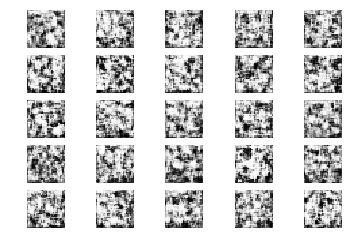

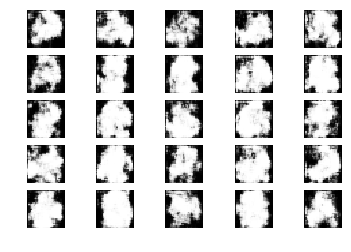

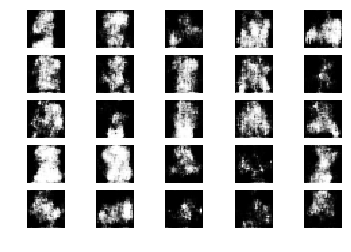

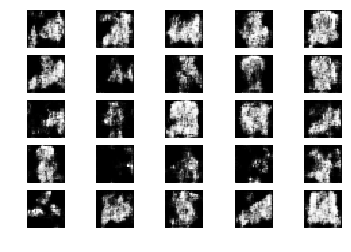

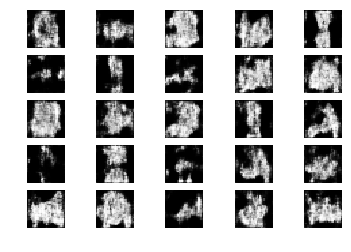

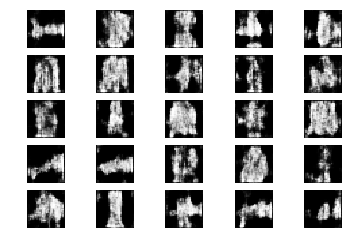

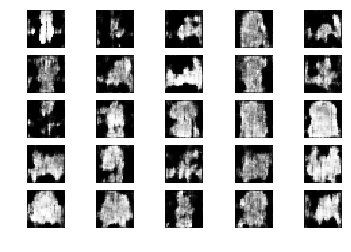

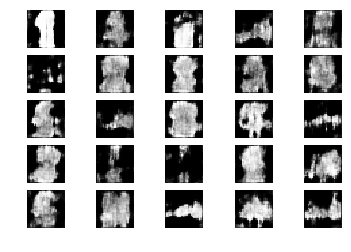

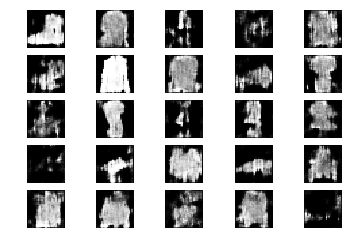

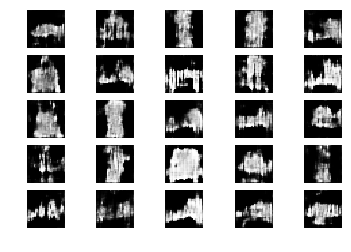

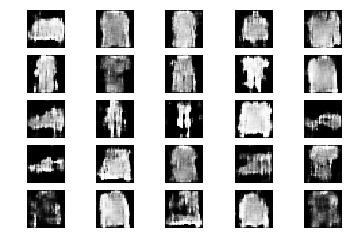

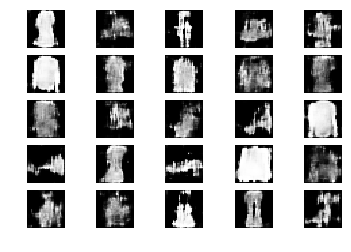

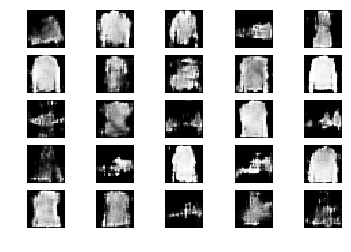

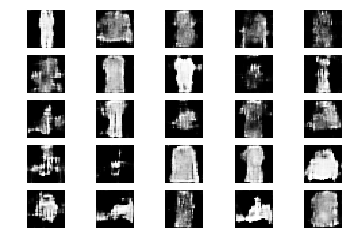

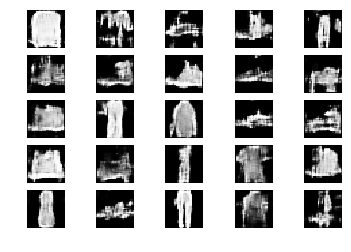

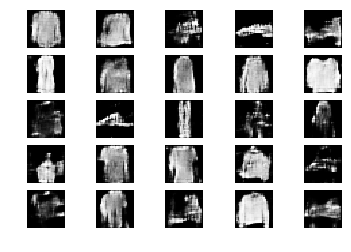

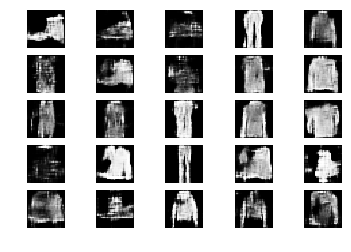

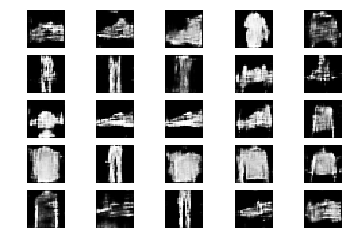

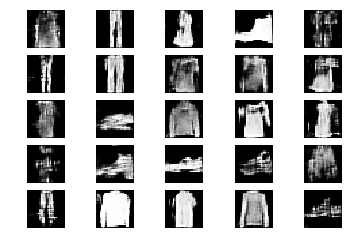

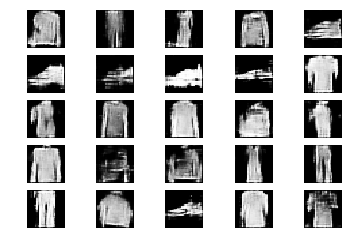

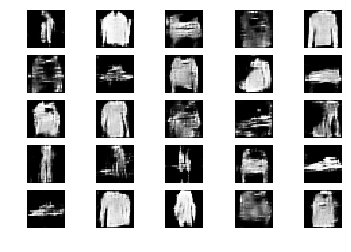

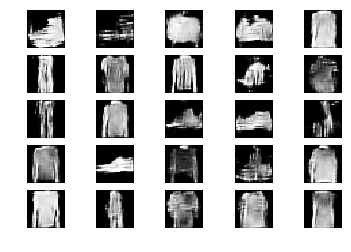

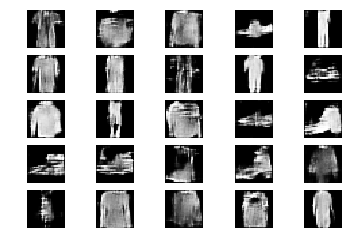

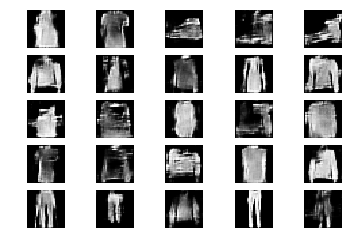

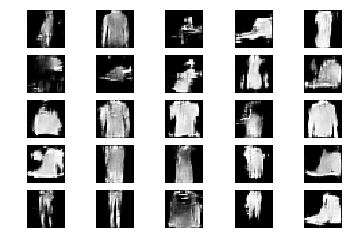

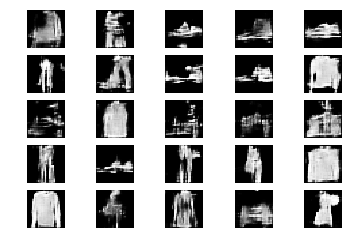

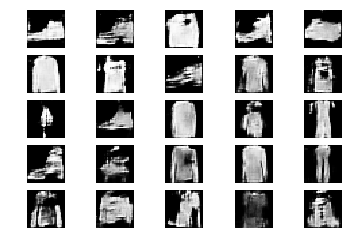

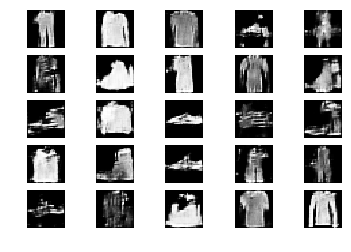

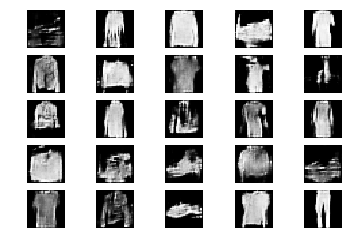

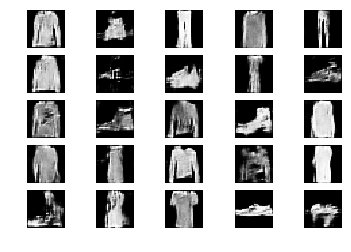

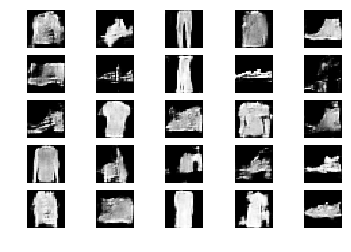

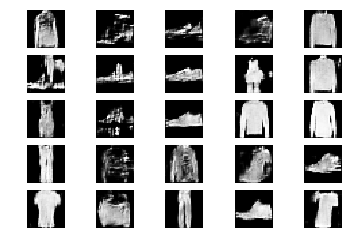

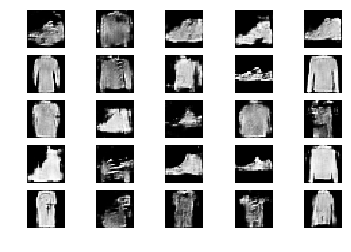

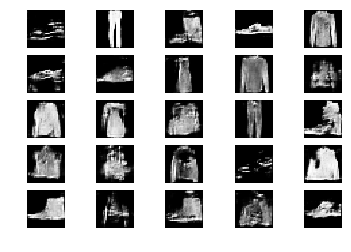

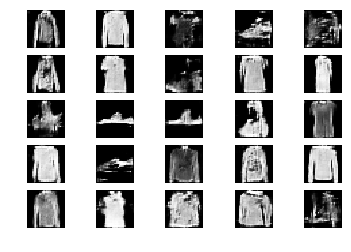

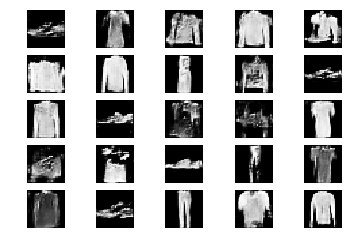

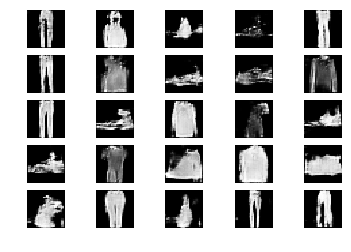

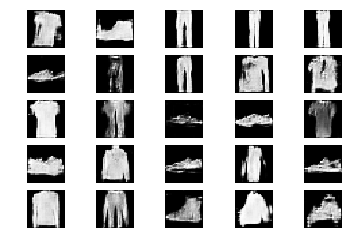

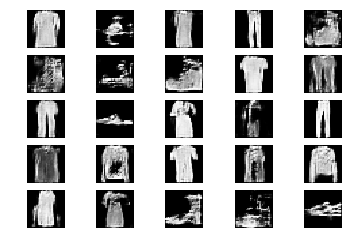

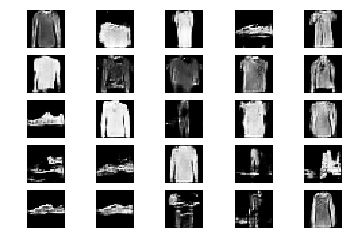

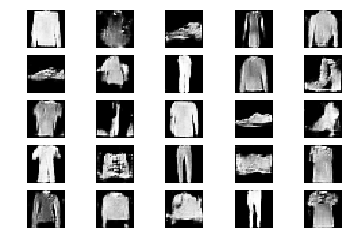

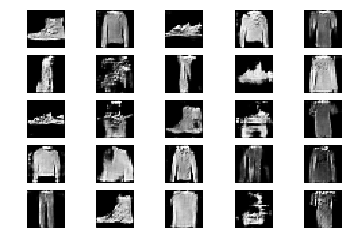

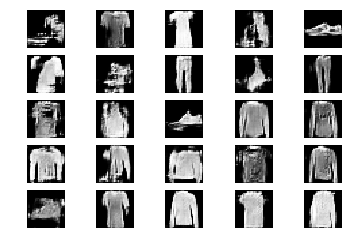

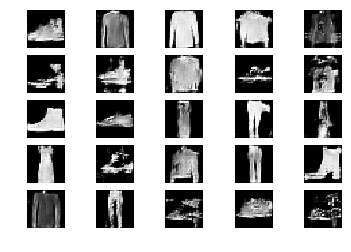

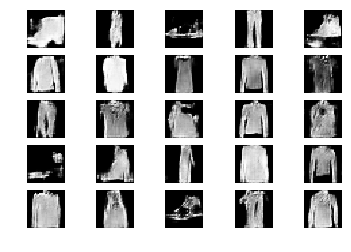

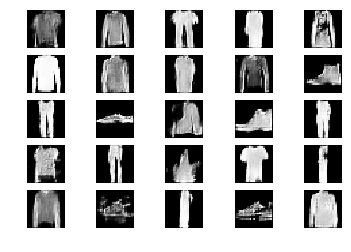

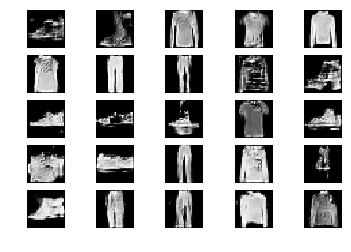

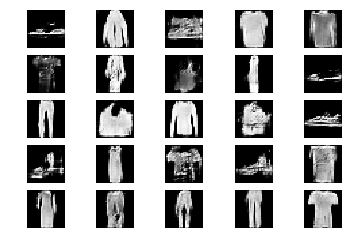

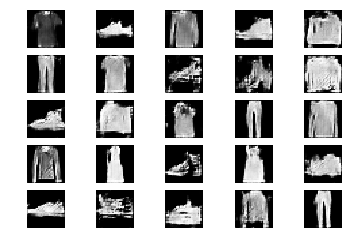

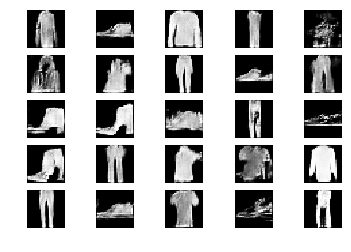

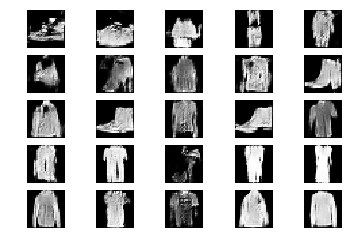

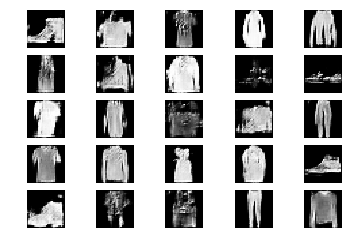

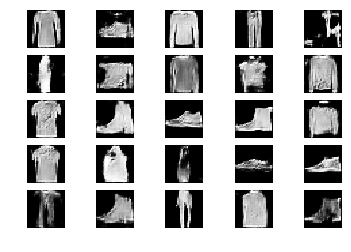

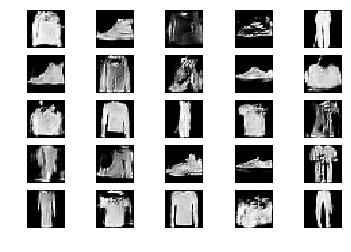

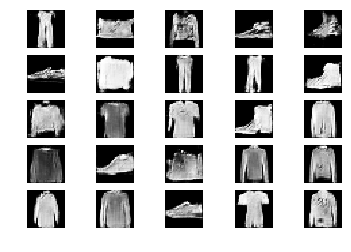

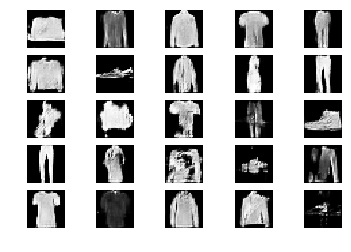

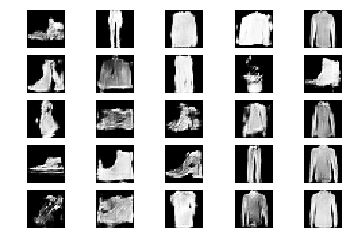

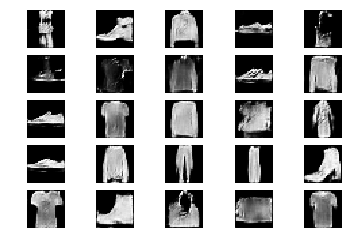

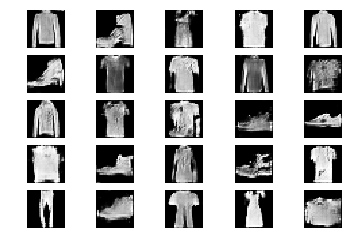

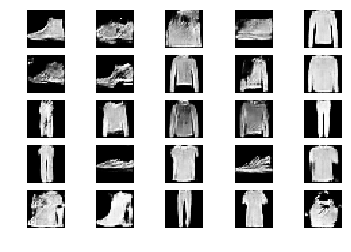

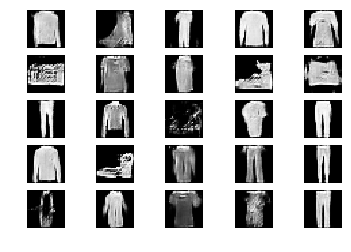

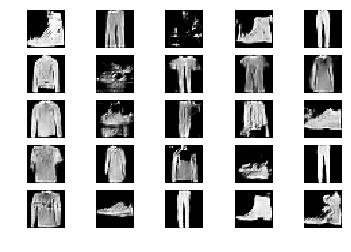

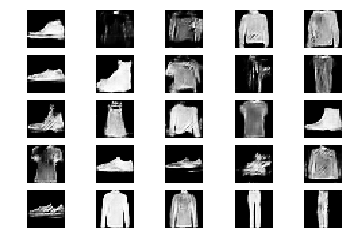

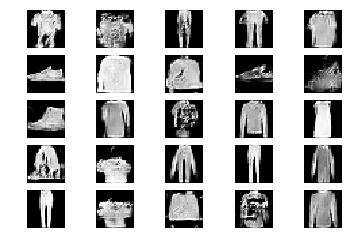

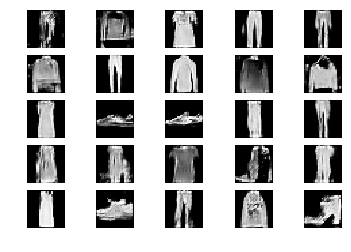

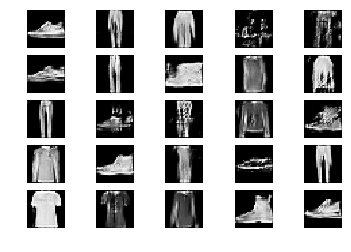

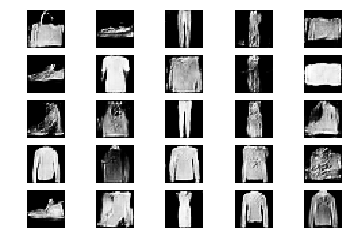

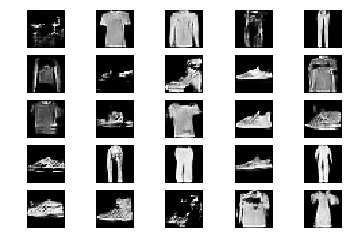

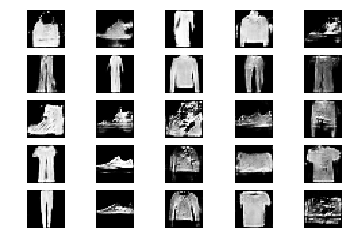

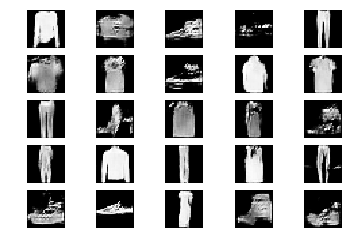

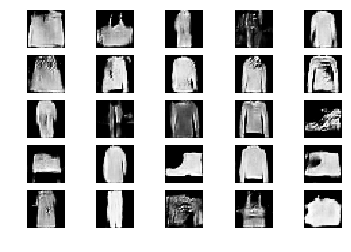

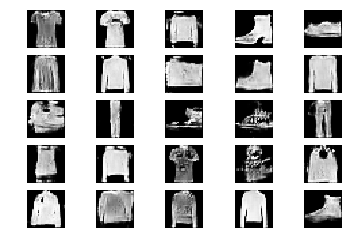

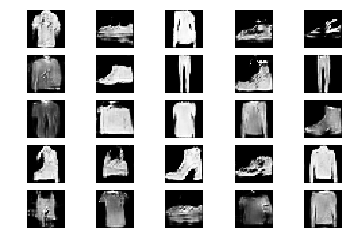

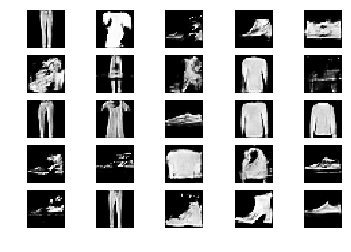

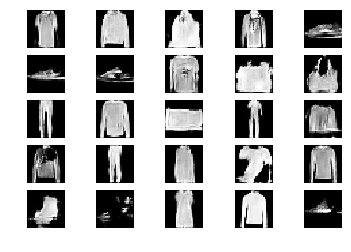

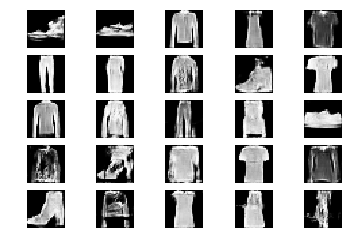

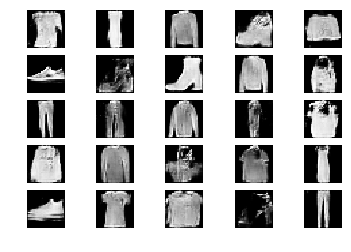

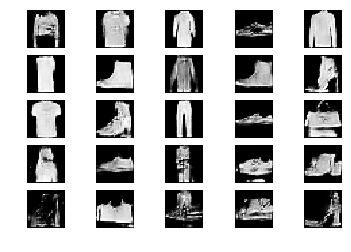

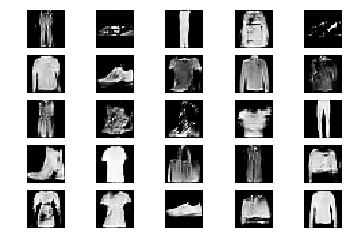

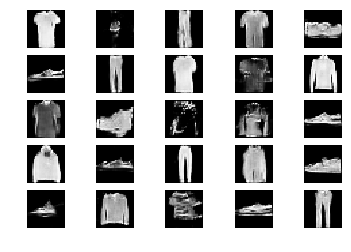

In [9]:
for epoch in range(epochs):
    # Select a random half of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)

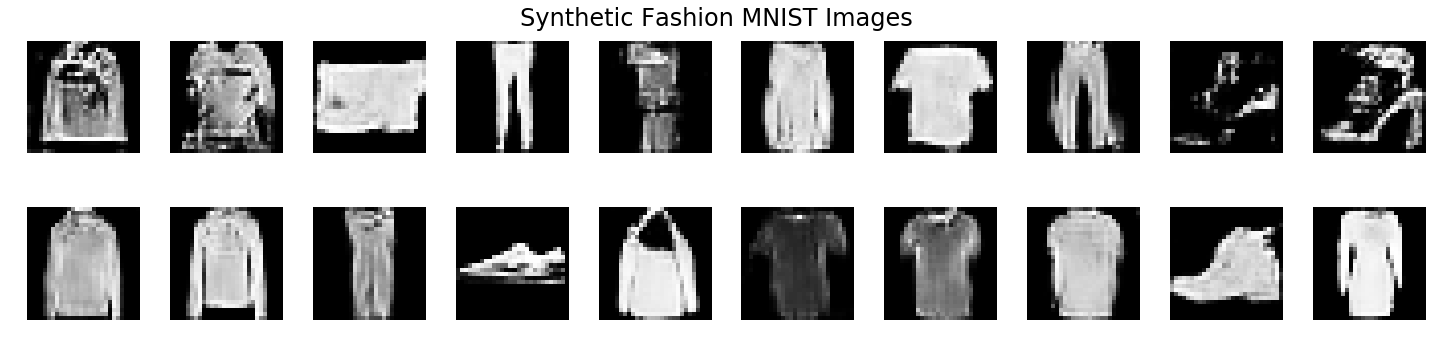

In [16]:
r, c = 2, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(20, 5))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

fig.suptitle('Synthetic Fashion MNIST Images', fontsize=24),
fig.tight_layout()
fig.subplots_adjust(top=.96)
fig.savefig('images/fashion_mnist.png', dpi=300)